In [1]:
# Import libraries
from scipy.optimize import minimize, NonlinearConstraint, shgo, differential_evolution
from aero_generation_updated0130 import generate_airfoil_dat_from_points
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator

import neuralfoil as nf
import numpy as np
from  xfoil_utils import compute_aerodynamic_coefficients
from  xfoil import  XFoil
from  xfoil.model import Airfoil

# Unneeded packages
# import subprocess
# import os
# import re
# from bayes_opt import BayesianOptimization

In [39]:
# Functions needed for the optimization problem

def airfoil_efficiency(linkage_coordinates, alpha_in=0, Re_in=4.6e6):
    """
    Calculates the inverse of the aerodynamic efficiency of an airfoil from associated linkage control points.

    Args:
     linkage_coordinates (vector) : A numpy array of control points (n  linkage_coordinates 2) where each row is [x, y].
     alpha_in (scalar) : desired angle of attack for optimization (default is 0).
        Re_in (scalar) : desired Reynolds number for optimization (default is 2x10^6).
    
    Returns:
        1/efficiency (scalar) : Inverse of aerodynamic efficiency of the input linkage geometry
    """
    
    airfoil_coordinates = generate_airfoil_dat_from_points(linkage_coordinates, trailing_edge_smooth_factor=0.1)
    aero = nf.get_aero_from_coordinates(  # You can use xy airfoil coordinates as an entry point
        coordinates=airfoil_coordinates,
        #alpha=alpha_in,  # Vectorize your evaluations across `alpha` and `Re`
        alpha=np.linspace(0, 15, 1000),  # Vectorize your evaluations across `alpha` and `Re`
        Re=Re_in,
        model_size="large"
    )
    #efficiency = aero['CL'][0]/aero['CD'][0]
    efficiency = np.max(aero['CL']/aero['CD'])

    inv_efficiency = 1/efficiency

    if efficiency < 0:
        #efficiency = 0.0000000000000000001
        inv_efficiency = 1000000000
    
    return inv_efficiency


In [ ]:
# Formulate and solve the optimization problem
# x = (x1, y1, x2, y2, x3, y3, x4, y4, y6) ---- 9 dimensions
# x = ( 0,  1,  2,  3,  4,  5,  6,  7,  8)
# Constraints
def equality_constraint_1(x):
    # l1^2 = l7^2
    return (x[0]**2 + x[1]**2) - ((x[6]-1)**2 + x[7]**2)

def equality_constraint_2(x):
    # l2^2 = l6^2
    return ((x[2] - x[0])**2 + (x[3] - x[1])**2) - ((x[6]-x[4])**2+(x[7]-x[5])**2)

def equality_constraint_3(x):
    # l3^2 = l5^2
    return ((1/2-x[2])**2 + (x[8] - x[3])**2) - ((x[4]-1/2)**2+(x[5]-x[8])**2)

def equality_constraint_4(x):
    # Pinned to rotate - x coordinate
    l3 = np.sqrt((1/2-x[2])**2+(x[8]-x[3])**2)
    l4 = np.sqrt((x[4]-x[2])**2+(x[5]-x[3])**2)
    val = np.sqrt(np.absolute(1-l4**2/(4*l3**2)))
    return x[4] - x[2] - l4*np.cos(np.arctan(val))

def equality_constraint_5(x):
    # Pinned to rotate - y coordinate
    l3 = np.sqrt((1/2-x[2])**2+(x[8]-x[3])**2)
    l4 = np.sqrt((x[4]-x[2])**2+(x[5]-x[3])**2)
    val = np.sqrt(np.absolute(1-l4**2/(4*l3**2)))
    return x[5] - x[3] - l4*np.sin(np.arctan(val))

def inequality_constraint_1(x):
    # 0.1 <= l1 <= 2 
    return x[0]**2 + x[1]**2

def inequality_constraint_2(x):
    # 0.1 <= l2 <= 2 
    return (x[2] - x[0])**2 + (x[3] - x[1])**2

def inequality_constraint_3(x):
    # 0.1 <= l3 <= 2 
    return (1/2-x[2])**2 + (x[8] - x[3])**2

def inequality_constraint_4(x):
    # 0.5 <= l4 <= 2
    return (x[4]-x[2])**2+(x[5]-x[3])**2

def inequality_constraint_5(x):
    l3 = np.sqrt((1/2-x[2])**2+(x[8]-x[3])**2)
    l4 = np.sqrt((x[4]-x[2])**2+(x[5]-x[3])**2)
    return l4**2/(4*l3**2)

def inequality_constraint_6(x):
    return x[3] - x[1] - 0.05

def inequality_constraint_7(x):
    return x[3] - x[5] - 0.05

def inequality_constraint_8(x):
    return x[5] - x[7] - 0.05

def inequality_constraint_9(x):
    return x[5] - x[8] - 0.05

def inequality_constraint_10(x):
    return 0 # x[1] - x[7] - 0.05

# Define Nonlinear Constraints
eq_constraint_1 = NonlinearConstraint(equality_constraint_1, 0, 0, keep_feasible=False)
eq_constraint_2 = NonlinearConstraint(equality_constraint_2, 0, 0, keep_feasible=False)
eq_constraint_3 = NonlinearConstraint(equality_constraint_3, 0, 0, keep_feasible=False)
eq_constraint_4 = NonlinearConstraint(equality_constraint_4, 0, 0, keep_feasible=False)
eq_constraint_5 = NonlinearConstraint(equality_constraint_5, 0, 0, keep_feasible=False)

ineq_constraint_1 = NonlinearConstraint(inequality_constraint_1, 0.01, 4, keep_feasible=False)
ineq_constraint_2 = NonlinearConstraint(inequality_constraint_2, 0.01, 4, keep_feasible=False)
ineq_constraint_3 = NonlinearConstraint(inequality_constraint_3, 0.01, 4, keep_feasible=False)
ineq_constraint_4 = NonlinearConstraint(inequality_constraint_4, 0.25, 4, keep_feasible=False)
ineq_constraint_5 = NonlinearConstraint(inequality_constraint_5, -np.inf, 1, keep_feasible=True)
ineq_constraint_6 = NonlinearConstraint(inequality_constraint_6, 0, np.inf, keep_feasible=False)
ineq_constraint_7 = NonlinearConstraint(inequality_constraint_7, 0, np.inf, keep_feasible=False)
ineq_constraint_8 = NonlinearConstraint(inequality_constraint_8, 0, np.inf, keep_feasible=False)
ineq_constraint_9 = NonlinearConstraint(inequality_constraint_9, 0, np.inf, keep_feasible=False)
ineq_constraint_10 = NonlinearConstraint(inequality_constraint_10, 0, np.inf, keep_feasible=False)

# Bounds
bounds = [(-5, -0.1), (0, 0.4), (-5, 5), (0.25, 0.4), (1/4, 5), (-0.2, 0.4), (1.5, 3), (-0.2, 0.4), (0.05, 1)]

# Initial Guess
# x0 = [-1/2, 1/4, 1/4, 1/2, 3/4, 1/2, 3/2, 1/4, 1/4]
# x0_1 = [-0.1421,    0.2831,   -0.0202,    0.7075,    1.2171,    0.6075,    1.4100,    0.0090,   -0.3980]
x0_1 = [-0.25,      0.25,      0.25,      0.5,       1/2+1/(2*np.sqrt(2)), 1/4,       1+1/(2*np.sqrt(2)),  0,       1/10]
x0_2 = [-0.2257,    0.2930,    0.2837,    0.3876,    0.9008,    0.3173,    1.3673,    0.0292,    0.1647]
x0_3 = [-0.2590,    0.1948,    0.2798,    0.3343,    0.7960,    0.2534,    1.3345,    0.0266,    0.1937] # symmetric
x0_4 = [-0.2257,    0.2930,    0.2837,    0.3876,    0.9008,    0.3173,    1.3673,    0.0292,    0.1647]
# -0.2257    0.2930    0.2837    0.3876    0.9008    0.3173    1.3673    0.0292    0.1647
# -0.2590    0.1948    0.2798    0.3343    0.7960    0.2534    1.3345    0.0266    0.1937
# -0.2413    0.2373    0.3127    0.3976    0.8056    0.3210    1.3492    0.0128    0.2328
# [-0.9886,    0.0427,   -0.2414,    0.0206,    1.2632,   -0.0560,    1.7374,   -0.6599,   -0.1127]
# [-0.4714,    0.3201,    0.4284,    0.4098,    0.6367,    0.3385,    1.5328,    0.1794,    0.4934]

#result = minimize(airfoil_efficiency, x0=[-0.25, 0.25, 0, 0.5, 1.25, 0.25, 1, 0.5, np.sqrt(5)/4, 0],  bounds=bounds, method='trust-constr', constraints=[eq_constraint_1, eq_constraint_2, eq_constraint_3, eq_constraint_4, eq_constraint_5, ineq_constraint_1, ineq_constraint_2, ineq_constraint_3, ineq_constraint_4, ineq_constraint_5, ineq_constraint_6, ineq_constraint_7, ineq_constraint_8, ineq_constraint_9, ineq_constraint_10], options={'verbose': 3, 'maxiter': 2000, 'gtol': 1e-6, 'barrier_tol': 1e-8, 'xtol': 1e-10})
#result = minimize(airfoil_efficiency, x0=[-0.5, np.sqrt(3)/2, 0, 1, 1+np.sqrt(3)/2, 0.5, np.sqrt(3)/2+np.sqrt(1/8+(1-np.sqrt(3)/2)**2), 0.75, 11/8-(np.sqrt(3)/2+np.sqrt(1/8+(1-np.sqrt(3)/2)**2)-1/2)**2*2, np.pi/2-np.arccos(1-(np.sqrt((np.sqrt(3)/2+np.sqrt(1/8+(1-np.sqrt(3)/2)**2))**2+1/8))**2/(2*(np.sqrt((-1/2)**2+(1-(11/8-(np.sqrt(3)/2+np.sqrt(1/8+(1-np.sqrt(3)/2)**2)-1/2)**2*2))**2))**2))], bounds=bounds, method='trust-constr', constraints=[eq_constraint_1, eq_constraint_2, eq_constraint_3, eq_constraint_4, eq_constraint_5, ineq_constraint_1, ineq_constraint_2, ineq_constraint_3, ineq_constraint_4, ineq_constraint_5, ineq_constraint_6, ineq_constraint_7, ineq_constraint_8, ineq_constraint_9, ineq_constraint_10], options={'verbose': 3, 'maxiter': 2000, 'gtol': 1e-6, 'barrier_tol': 1e-8, 'xtol': 1e-10})
#result = minimize(airfoil_efficiency, x0=[-0.5, np.sqrt(3)/2, 0, 1, 1+np.sqrt(3)/2, -0.5, (5+2*np.sqrt(3))/4, (1-3*np.sqrt(3))/2, 0.54, 0.1713], bounds=bounds, method='trust-constr', constraints=[eq_constraint_1, eq_constraint_2, eq_constraint_3, eq_constraint_4, eq_constraint_5, ineq_constraint_1, ineq_constraint_2, ineq_constraint_3, ineq_constraint_4, ineq_constraint_5, ineq_constraint_6, ineq_constraint_7, ineq_constraint_8, ineq_constraint_9, ineq_constraint_10], options={'verbose': 3, 'maxiter': 2000, 'gtol': 1e-6, 'barrier_tol': 1e-8, 'xtol': 1e-10})
#result2 = minimize(airfoil_efficiency, x0=x0, bounds=bounds, method='trust-constr', constraints=[eq_constraint_1, eq_constraint_2, eq_constraint_3, eq_constraint_4, eq_constraint_5, ineq_constraint_1, ineq_constraint_2, ineq_constraint_3, ineq_constraint_4, ineq_constraint_5, ineq_constraint_6, ineq_constraint_7, ineq_constraint_8, ineq_constraint_9, ineq_constraint_10], options={'verbose': 3, 'maxiter': 2000, 'gtol': 1e-6, 'barrier_tol': 1e-8, 'xtol': 1e-10})

#result_1 = minimize(airfoil_efficiency, x0=x0_1, bounds=bounds, method='trust-constr', constraints=[eq_constraint_1, eq_constraint_2, eq_constraint_3, eq_constraint_4, eq_constraint_5, ineq_constraint_1, ineq_constraint_2, ineq_constraint_3, ineq_constraint_4, ineq_constraint_5, ineq_constraint_6, ineq_constraint_7, ineq_constraint_8, ineq_constraint_9, ineq_constraint_10], options={'verbose': 3, 'maxiter': 2500, 'gtol': 1e-6, 'barrier_tol': 1e-8, 'xtol': 1e-10})
result_2 = minimize(airfoil_efficiency, x0=x0_2, bounds=bounds, method='trust-constr', constraints=[eq_constraint_1, eq_constraint_2, eq_constraint_3, eq_constraint_4, eq_constraint_5, ineq_constraint_1, ineq_constraint_2, ineq_constraint_3, ineq_constraint_4, ineq_constraint_5, ineq_constraint_6, ineq_constraint_7, ineq_constraint_8, ineq_constraint_9, ineq_constraint_10], options={'verbose': 3, 'maxiter': 100, 'gtol': 1e-6, 'barrier_tol': 1e-8, 'xtol': 1e-10})
result_3 = minimize(airfoil_efficiency, x0=x0_3, bounds=bounds, method='trust-constr', constraints=[eq_constraint_1, eq_constraint_2, eq_constraint_3, eq_constraint_4, eq_constraint_5, ineq_constraint_1, ineq_constraint_2, ineq_constraint_3, ineq_constraint_4, ineq_constraint_5, ineq_constraint_6, ineq_constraint_7, ineq_constraint_8, ineq_constraint_9, ineq_constraint_10], options={'verbose': 3, 'maxiter': 100, 'gtol': 1e-6, 'barrier_tol': 1e-8, 'xtol': 1e-10})
result_4 = minimize(airfoil_efficiency, x0=x0_4, bounds=bounds, method='trust-constr', constraints=[eq_constraint_1, eq_constraint_2, eq_constraint_3, eq_constraint_4, eq_constraint_5, ineq_constraint_1, ineq_constraint_2, ineq_constraint_3, ineq_constraint_4, ineq_constraint_5, ineq_constraint_6, ineq_constraint_7, ineq_constraint_8, ineq_constraint_9, ineq_constraint_10], options={'verbose': 3, 'maxiter': 100, 'gtol': 1e-6, 'barrier_tol': 1e-8, 'xtol': 1e-10})
#result_5 = minimize(airfoil_efficiency, x0=x0_6, bounds=bounds, method='trust-constr', constraints=[eq_constraint_1, eq_constraint_2, eq_constraint_3, eq_constraint_4, eq_constraint_5, ineq_constraint_1, ineq_constraint_2, ineq_constraint_3, ineq_constraint_4, ineq_constraint_5, ineq_constraint_6, ineq_constraint_7, ineq_constraint_8, ineq_constraint_9, ineq_constraint_10], options={'verbose': 3, 'maxiter': 2500, 'gtol': 1e-6, 'barrier_tol': 1e-8, 'xtol': 1e-10})

# result = minimize(airfoil_efficiency, x0=[-0.25, 0.25, 0.25, 0.5, 1/2+1/(2*np.sqrt(2)), 1/4, 1+1/(2*np.sqrt(2)), 0, 1/10], bounds=bounds, method='trust-constr', constraints=[eq_constraint_1, eq_constraint_2, eq_constraint_3, eq_constraint_4, eq_constraint_5, ineq_constraint_1, ineq_constraint_2, ineq_constraint_3, ineq_constraint_4, ineq_constraint_5, ineq_constraint_6, ineq_constraint_7, ineq_constraint_8, ineq_constraint_9, ineq_constraint_10], options={'verbose': 3, 'maxiter': 2000, 'gtol': 1e-6, 'barrier_tol': 1e-8, 'xtol': 1e-10})

#print("Optimal solution:", result.x)
print('Optimization Complete')

In [45]:
# Small tolerance for relaxed equality constraints
epsilon = 1e-2

# Relaxed constraints: converting equality constraints to inequality with tolerance
constraints = [
    {'type': 'ineq', 'fun': lambda x: epsilon - abs((x[0]**2 + x[1]**2) - ((x[6]-1)**2 + x[7]**2))},  # l1^2 = l7^2 (relaxed)
    {'type': 'ineq', 'fun': lambda x: epsilon - abs(((x[2] - x[0])**2 + (x[3] - x[1])**2) - ((x[6]-x[4])**2+(x[7]-x[5])**2))},  # l2^2 = l6^2 (relaxed)
    {'type': 'ineq', 'fun': lambda x: epsilon - abs(((1/2-x[2])**2 + (x[8] - x[3])**2) - ((x[4]-1/2)**2+(x[5]-x[8])**2))},  # l3^2 = l5^2 (relaxed)
    
    # Convert equality constraints for pinned points to inequalities
    # {'type': 'ineq', 'fun': lambda x: epsilon - abs((x[4] - x[2])**2 - (1 - ((x[4]-x[2])**2 + (x[5]-x[3])**2) / (4 * ((1/2-x[2])**2+(x[8]-x[3])**2))))},  # Pinned x (relaxed)
    # {'type': 'ineq', 'fun': lambda x: epsilon - abs((x[5] - x[3])**2 - (1 - ((x[4]-x[2])**2 + (x[5]-x[3])**2) / (4 * ((1/2-x[2])**2+(x[8]-x[3])**2))))},  # Pinned y (relaxed)
    {'type': 'ineq', 'fun': lambda x: epsilon - abs(x[4] - x[2] - (np.sqrt((x[4]-x[2])**2+(x[5]-x[3])**2))*np.cos(np.arctan(np.sqrt(np.absolute(1-(np.sqrt((x[4]-x[2])**2+(x[5]-x[3])**2))**2/(4*(np.sqrt((1/2-x[2])**2+(x[8]-x[3])**2))**2))))))},  # Pinned x (relaxed)
    {'type': 'ineq', 'fun': lambda x: epsilon - abs(x[5] - x[3] + (np.sqrt((x[4]-x[2])**2+(x[5]-x[3])**2))*np.sin(np.arctan(np.sqrt(np.absolute(1-(np.sqrt((x[4]-x[2])**2+(x[5]-x[3])**2))**2/(4*(np.sqrt((1/2-x[2])**2+(x[8]-x[3])**2))**2))))))},  # Pinned y (relaxed)
    
    # Inequality constraints (apply penalties if violated)
    # {'type': 'ineq', 'fun': lambda x: x[0]**2 + x[1]**2 - 0.1},  # 0.1 <= l1
    # {'type': 'ineq', 'fun': lambda x: (x[2] - x[0])**2 + (x[3] - x[1])**2 - 0.1},  # 0.1 <= l2
    # {'type': 'ineq', 'fun': lambda x: (1/2-x[2])**2 + (x[8] - x[3])**2 - 0.1},  # 0.1 <= l3
    #{'type': 'ineq', 'fun': lambda x: (x[4]-x[2])**2+(x[5]-x[3])**2 + 0.4},  # 0.1 <= l4^2
    #{'type': 'ineq', 'fun': lambda x: ((x[4] - x[2])**2 + (x[5] - x[3])**2) / (4 * ((1/2 - x[2])**2 + (x[8] - x[3])**2)) - 1.0}, 
    #{'type': 'ineq', 'fun': lambda x: - x[1] + x[3]},
    #{'type': 'ineq', 'fun': lambda x: - x[3] + x[5]},
    #{'type': 'ineq', 'fun': lambda x: - x[5] + x[7]},
    #{'type': 'ineq', 'fun': lambda x: - x[5] + x[8]},
    #{'type': 'ineq', 'fun': lambda x: - x[1] + x[7]},
    {'type': 'ineq', 'fun': lambda x: - x[0] + x[2]},
]

#bounds = [(-5, -0.1), (0, 0.5), (-0.1, 0.2), (-5, 5), (0.5, 5), (0.4, 0.6), (0.5, 5), (-0.2, 0.25), (0, 1)]
#bounds = [(-5, -0.1), (0, 0.5), (-0.5, 0.5), (0.2, 0.5), (1, 5), (0.2, 0.4), (1.1, 3), (-0.1, 0.25), (0.05, 1)]
#bounds = [(-5, 0), (0, 5), (-5, 5), (0, 0.35), (0.5, 0.95), (0, 5), (1, 5), (-0.1, 5), (-5, 5), (0, 0.1)] These were the last bounds used
bounds = [(-5, 0), (0, 5), (0, 5), (0, 0.75), (0.5, 1.5), (0, 5), (1, 5), (-0.151, 5), (-5, 5), (0, 0.1)]
#bounds = [(-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5)]

#x0 = [-0.2257,    0.2930,    0.2837,    0.3876,    0.9008,    0.3173,    1.3673,    0.0292,    0.1647]
x0_1 = [-0.252, 0.160, -0.01, 0.304, 1.069, 0.09, 1.288, -0.084, 0.05, 0.1]
x0_2 = [-0.208, 0.243, 0.038, 0.377, 1.089, 0.051, 1.282, -0.151, 0.01, 0.1]
x0_3 = [-0.315, 0.057, 0.033, 0.265, 1.062, 0.17, 1.311, -0.077, 0.05, 0.1]
x0_4 = [-0.31, 0.079, 0.026, 0.283, 1.066, 0.15, 1.3, -0.11, 0.05, 0.1]

options = {'initial_tr_radius': 0.01, 'verbose': 3, 'maxiter': 2000, 'barrier_tol': 1e-8, 'gtol': 1e-9, 'finite_diff_rel_step': 1e-5}
result_1 = minimize(airfoil_efficiency, x0_1, method='trust-constr', bounds=bounds, constraints=constraints, options=options)
result_2 = minimize(airfoil_efficiency, x0_2, method='trust-constr', bounds=bounds, constraints=constraints, options=options)
result_3 = minimize(airfoil_efficiency, x0_3, method='trust-constr', bounds=bounds, constraints=constraints, options=options)
result_4 = minimize(airfoil_efficiency, x0_4, method='trust-constr', bounds=bounds, constraints=constraints, options=options)

# Print results
# print("Optimal solution:", result.x)
print("Optimal efficiency 1:", 1/result_1.fun)
print("Optimal efficiency 2:", 1/result_2.fun)
print("Optimal efficiency 3:", 1/result_3.fun)
print("Optimal efficiency 4:", 1/result_4.fun)

print("Success 1:", result_1.success)
print("Success 2:", result_2.success)
print("Success 3:", result_3.success)
print("Success 4:", result_4.success)
# print("Message:", result.message)
# print("Optimality value:", result.optimality)

print('Optimization Complete')

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |  11   |   0   | +2.1400e-02 | 1.00e-02 | 1.00e-01 | 5.38e-02 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |  22   |   1   | +2.0931e-02 | 7.00e-02 | 7.58e-02 | 4.74e-02 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |  33   |   7   | +2.0513e-02 | 4.88e-01 | 9.67e-02 | 5.72e-03 | 1.00e+00 |  1.00e-01   |   4   |
|   4   |  44   |  10   | +1.2410e-02 | 3.42e+00 | 5.36e-02 | 2.14e-01 | 1.00e+00 |  1.00e-01   |   2   |
|   5   |  55   |  19   | +2.2322e-02 | 1.45e+01 | 4.86e-02 | 1.11e-01 | 1.00e+00 |  1.00e-01   |   4   |
|   6   |  66   |  25   | +2.2322e-02 | 1.45e+00 | 4.86e-02 | 1.11e-01 | 1.00e+00 |  1.00e-01   |   4   |
|   7   |  77   |  31   | +2.2322e-02 | 7.24e-01 | 4.86e-02 | 1.11e-01 | 1.00e+00 |  1.00e-01   |   4   |
|   8   |  88   |  34   | +2.8789e-02 | 1.45e+

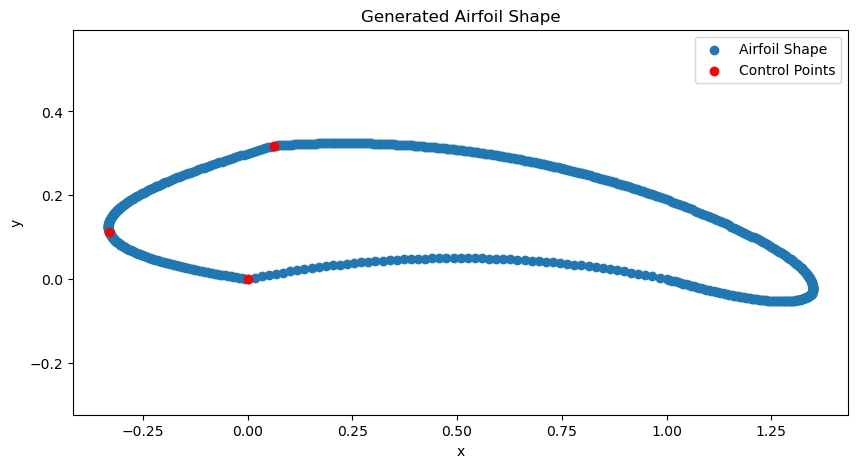

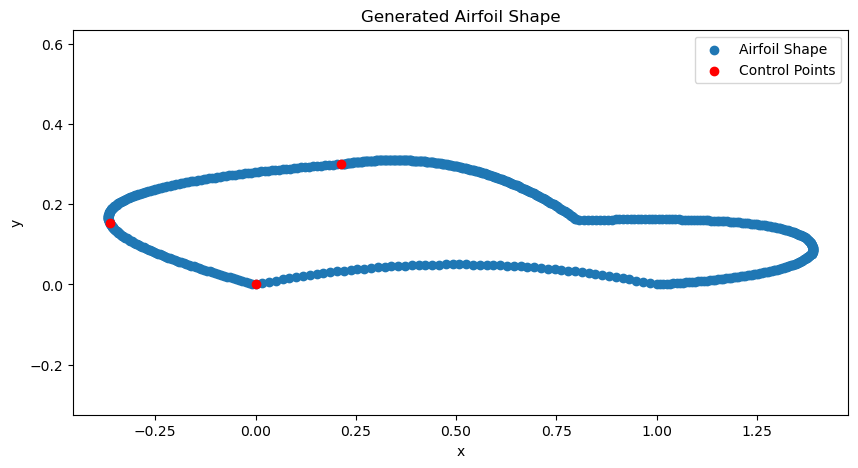

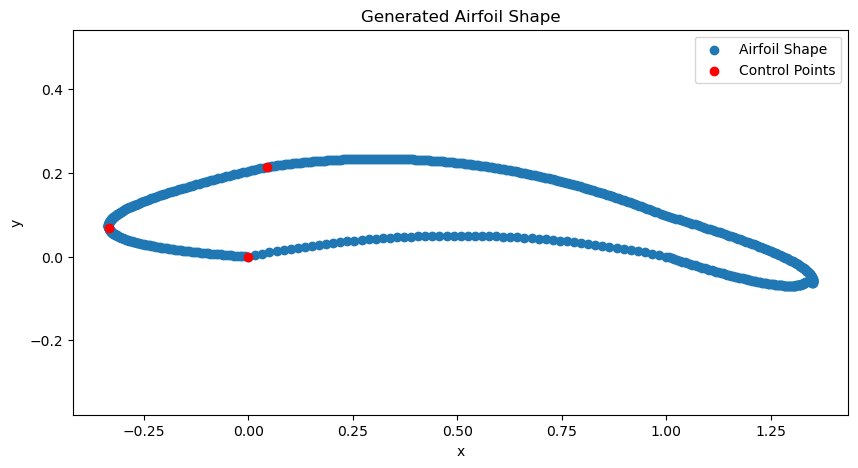

Dat file successfully written


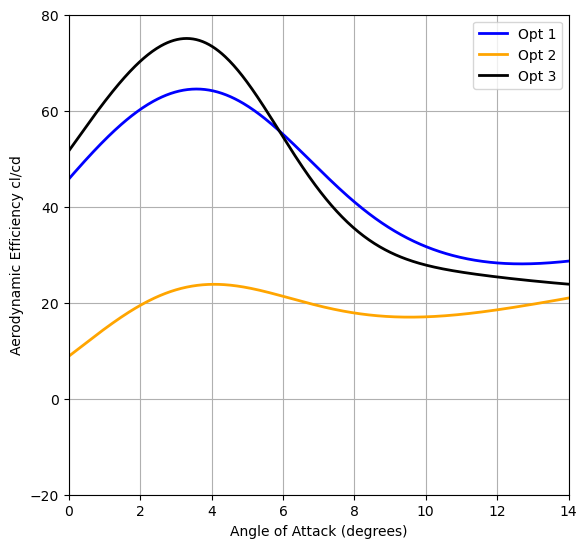

In [95]:
# efficiency = airfoil_efficiency(result.x)
# coords = generate_airfoil_dat_from_points(result.x, display_plot=True, trailing_edge_smooth_factor=0.1, export_dat=True)
# print(result.x)

efficiency_1 = airfoil_efficiency(result_1.x)
coords_1 = generate_airfoil_dat_from_points(result_1.x, display_plot=True, trailing_edge_smooth_factor=0.1, export_dat=False)

efficiency_2 = airfoil_efficiency(result_2.x)
coords_2 = generate_airfoil_dat_from_points(result_2.x, display_plot=True, trailing_edge_smooth_factor=0.1, export_dat=False)

efficiency_3 = airfoil_efficiency(result_3.x)
coords_3 = generate_airfoil_dat_from_points(result_3.x, display_plot=True, trailing_edge_smooth_factor=0.1, export_dat=True)

# efficiency_4 = airfoil_efficiency(result_4.x)
# coords_4 = generate_airfoil_dat_from_points(result_4.x, display_plot=True, trailing_edge_smooth_factor=0.1, export_dat=False)

aero_gen_1 = nf.get_aero_from_coordinates(  # You can use xy airfoil coordinates as an entry point
        coordinates=coords_1,
        alpha=np.linspace(-10, 20, 1000),  # Vectorize your evaluations across `alpha` and `Re`
        Re=4.6e6,
        model_size="xxxlarge"
)

aero_gen_2 = nf.get_aero_from_coordinates(  # You can use xy airfoil coordinates as an entry point
        coordinates=coords_2,
        alpha=np.linspace(-10, 20, 1000),  # Vectorize your evaluations across `alpha` and `Re`
        Re=4.6e6,
        model_size="xxxlarge"
)

aero_gen_3 = nf.get_aero_from_coordinates(  # You can use xy airfoil coordinates as an entry point
        coordinates=coords_3,
        alpha=np.linspace(-10, 20, 1000),  # Vectorize your evaluations across `alpha` and `Re`
        Re=4.6e6,
        model_size="xxxlarge"
)

# aero_gen_4 = nf.get_aero_from_coordinates(  # You can use xy airfoil coordinates as an entry point
#         coordinates=coords_4,
#         alpha=np.linspace(-10, 20, 1000),  # Vectorize your evaluations across `alpha` and `Re`
#         Re=4.5e6,
#         model_size="large"
# )

fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([0.1,0.1,0.5,0.8])
ax.plot(np.linspace(-10, 20, 1000), aero_gen_1['CL']/aero_gen_1['CD'], label="Optimization 1", linewidth=2, color="blue")
ax.plot(np.linspace(-10, 20, 1000), aero_gen_2['CL']/aero_gen_2['CD'], label="Optimization 2", linewidth=2, color="orange")
ax.plot(np.linspace(-10, 20, 1000), aero_gen_3['CL']/aero_gen_3['CD'], label="Optimization 3", linewidth=2, color="black")
#ax.plot(np.linspace(-10, 20, 1000), aero_gen_4['CL']/aero_gen_4['CD'], label="Optimization 4", linewidth=2)
plt.xlabel("Angle of Attack (degrees)")
plt.ylabel("Aerodynamic Efficiency cl/cd")
plt.legend(labels=['Opt 1', 'Opt 2', 'Opt 3', 'Opt 4'], loc='upper right')
#plt.axis("equal")
plt.grid()
plt.xlim(0, 14) 
plt.ylim(-20, 80) 
#plt.show()

plt.savefig("initialization_graph.svg", format="svg")

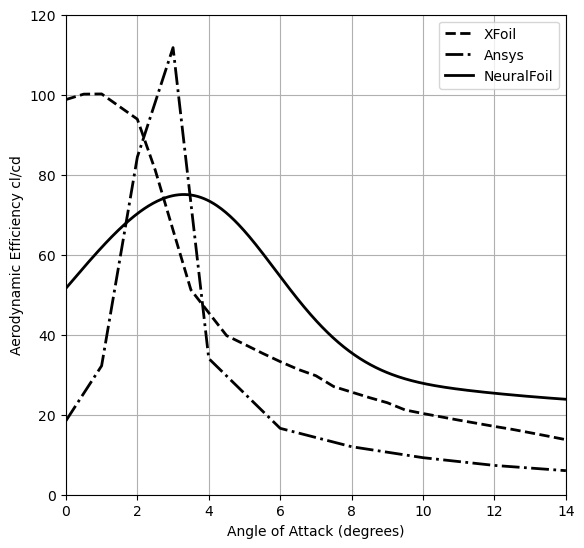

In [99]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([0.1,0.1,0.5,0.8])
#ax.plot(np.linspace(-10, 20, 1000), aero_gen_1['CL']/aero_gen_1['CD'], label="Optimization 1", linewidth=2, color="blue")
#ax.plot(np.linspace(-10, 20, 1000), aero_gen_2['CL']/aero_gen_2['CD'], label="Optimization 2", linewidth=2, color="orange")
ax.plot([0, 0.5, 1, 2, 2.5, 3, 3.5, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14], [98.78771552, 100.1483051, 100.1958763, 93.89199255, 81.18747458, 66.16271186, 51.21984278, 39.77657131, 37.60146888, 35.38118193, 33.27890483, 31.34228188, 29.74886493, 27.0381307, 25.6545193, 24.27181208, 22.99926771, 21.18786127, 20.30073818, 19.47382063, 18.6448177, 17.86408522, 17.07576429, 16.33579725, 15.495909, 14.64270029, 13.75966476], label="XFoil", linewidth=2, color="black", linestyle='--')
ax.plot([0, 1, 2, 3, 4, 6, 8, 10, 12, 14], [18.48, 32.23, 84.40, 111.78, 34.05, 16.60, 12.00, 9.26, 7.323798172, 6.013731343], label="Ansys Fluent", linewidth=2, color="black", linestyle='-.')
ax.plot(np.linspace(-10, 20, 1000), aero_gen_3['CL']/aero_gen_3['CD'], label="NeuralFoil", linewidth=2, color="black")
#ax.plot(np.linspace(-10, 20, 1000), aero_gen_4['CL']/aero_gen_4['CD'], label="Optimization 4", linewidth=2)
plt.xlabel("Angle of Attack (degrees)")
plt.ylabel("Aerodynamic Efficiency cl/cd")
plt.legend(labels=['XFoil', 'Ansys', 'NeuralFoil'], loc='upper right')
#plt.axis("equal")
plt.grid()
plt.xlim(0, 14) 
plt.ylim(0, 120) 
#plt.show()

plt.savefig("type_graph.svg", format="svg")

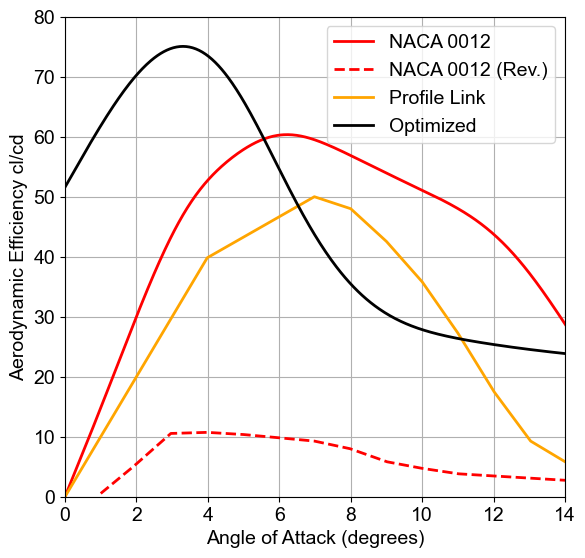

In [104]:
# Airfoil coordinates for the latest hex wing
airfoil_coordinates_hex = np.array([
    [0.3903266489505768, -0.06929851323366165],
    [0.38489288091659546, -0.08071257174015045],
    [0.37522220611572266, -0.0880802795290947],
    [0.3629175126552582, -0.09223213791847229],
    [0.34958186745643616, -0.09399862587451935],
    [0.3368181586265564, -0.09421023726463318],
    [0.326229453086853, -0.09369747340679169],
    [0.31941866874694824, -0.09329081326723099],
    [0.29970091581344604, -0.09140316396951675],
    [0.2775585949420929, -0.08703729510307312],
    [0.25495582818984985, -0.08120181411504745],
    [0.2338566929101944, -0.07490532100200653],
    [0.21622531116008759, -0.06915641576051712],
    [0.2040257602930069, -0.06496371328830719],
    [0.1992221474647522, -0.06333579123020172],
    [0.12573304772377014, -0.062590092420578],
    [0.02023281902074814, -0.062387291342020035],
    [-0.10169284045696259, -0.06253783404827118],
    [-0.224458247423172, -0.0628521740436554],
    [-0.3324776887893677, -0.06314075738191605],
    [-0.4101654887199402, -0.06321404129266739],
    [-0.4419359564781189, -0.06288247555494308],
    [-0.47388699650764465, -0.05608212202787399],
    [-0.5058854222297668, -0.046457309275865555],
    [-0.5362880229949951, -0.03462802246212959],
    [-0.5634514093399048, -0.021214250475168228],
    [-0.5857322812080383, -0.006835982669144869],
    [-0.6014872789382935, 0.007886792533099651],
    [-0.609073281288147, 0.022334089502692223],
    [-0.5989988446235657, 0.0466727539896965],
    [-0.5645560622215271, 0.06956399232149124],
    [-0.5149900317192078, 0.09018311649560928],
    [-0.45954594016075134, 0.10770541429519653],
    [-0.4074687063694, 0.12130620330572128],
    [-0.3680035471916199, 0.13016079366207123],
    [-0.35039547085762024, 0.13344444334506989],
    [-0.29723984003067017, 0.1347549706697464],
    [-0.2436310201883316, 0.13293136656284332],
    [-0.19251486659049988, 0.1290137618780136],
    [-0.1468372941017151, 0.12404230982065201],
    [-0.10954420268535614, 0.11905713379383087],
    [-0.08358149975538254, 0.11509837955236435],
    [-0.07189507782459259, 0.1132061779499054],
    [-0.029206249862909317, 0.10573934763669968],
    [0.012118915095925331, 0.0963510051369667],
    [0.05045080557465553, 0.08610666543245316],
    [0.08415980637073517, 0.0760718509554863],
    [0.11161631345748901, 0.0673120841383934],
    [0.1311907321214676, 0.06089287996292114],
    [0.14125344157218933, 0.057879772037267685],
    [0.1590498834848404, 0.05329344794154167],
    [0.19075749814510345, 0.04385573789477348],
    [0.23125500977039337, 0.030555862933397293],
    [0.2754211127758026, 0.014383033849298954],
    [0.31813445687294006, -0.0036735250614583492],
    [0.3542737662792206, -0.022624598816037178],
    [0.37871769070625305, -0.041480980813503265],
    [0.38118213415145874, -0.04418718069791794],
    [0.38362157344818115, -0.04703349247574806],
    [0.385907381772995, -0.05010122060775757],
    [0.387910932302475, -0.05347165837883949],
    [0.3895035684108734, -0.05722609907388687],
    [0.3905567526817322, -0.06144583970308304],
    [0.3909417688846588, -0.06621217727661133]
])

airfoil_coordinates_slat = np.array([
    [0.5004816651344299, -0.0209413543343544],
    [0.4997352659702301, -0.02496359497308731],
    [0.49783429503440857, -0.027851440012454987],
    [0.4949307143688202, -0.029969053342938423],
    [0.49117645621299744, -0.031680598855018616],
    [0.48672348260879517, -0.03335024416446686],
    [0.48172372579574585, -0.035342153161764145],
    [0.48073387145996094, -0.03575047850608826],
    [0.4794543981552124, -0.03602335602045059],
    [0.4770110547542572, -0.03621742129325867],
    [0.47252970933914185, -0.0363892987370491],
    [0.4651360809803009, -0.03659562021493912],
    [0.4539560079574585, -0.03689301013946533],
    [0.4475541114807129, -0.0370873287320137],
    [0.44055455923080444, -0.03733092173933983],
    [0.43357160687446594, -0.037593774497509],
    [0.4272195100784302, -0.03784586489200592],
    [0.42211249470710754, -0.038057178258895874],
    [0.4188648760318756, -0.03819769620895386],
    [0.411889910697937, -0.03851289302110672],
    [0.40384015440940857, -0.038878969848155975],
    [0.3955839276313782, -0.0392567478120327],
    [0.38798952102661133, -0.039607055485248566],
    [0.3819253444671631, -0.03989071771502495],
    [0.3782595992088318, -0.04006856307387352],
    [0.28260040283203125, -0.04386269301176071],
    [0.13159874081611633, -0.04880732670426369],
    [-0.04248398542404175, -0.054069630801677704],
    [-0.20738649368286133, -0.05881676822900772],
    [-0.33084744215011597, -0.0622159019112587],
    [-0.3806057572364807, -0.06343420594930649],
    [-0.3907749056816101, -0.06283187866210938],
    [-0.3998897075653076, -0.062453486025333405],
    [-0.4077691435813904, -0.0622231587767601],
    [-0.4142320156097412, -0.062065012753009796],
    [-0.4190971255302429, -0.06190318614244461],
    [-0.42218345403671265, -0.06166180223226547],
    [-0.43180781602859497, -0.06037028133869171],
    [-0.43967360258102417, -0.059457048773765564],
    [-0.4459553360939026, -0.05881905555725098],
    [-0.450827419757843, -0.05835328251123428],
    [-0.4544643759727478, -0.057956673204898834],
    [-0.4570406675338745, -0.05752619355916977],
    [-0.4660440683364868, -0.055446065962314606],
    [-0.4724152088165283, -0.053928442299366],
    [-0.47665953636169434, -0.052853815257549286],
    [-0.4792824983596802, -0.0521027073264122],
    [-0.48078954219818115, -0.05155560374259949],
    [-0.4816861152648926, -0.05109303072094917],
    [-0.4884525537490845, -0.046627290546894073],
    [-0.49324893951416016, -0.042691636830568314],
    [-0.49634480476379395, -0.03923330083489418],
    [-0.49800950288772583, -0.03619951754808426],
    [-0.4985126852989197, -0.03353751823306084],
    [-0.49812382459640503, -0.031194541603326797],
    [-0.4956187605857849, -0.02499433420598507],
    [-0.4926851987838745, -0.020305870100855827],
    [-0.4887728691101074, -0.016073256731033325],
    [-0.48333144187927246, -0.011240605264902115],
    [-0.47581082582473755, -0.004752025008201599],
    [-0.46566063165664673, 0.004448369145393372],
    [-0.46373212337493896, 0.005691729485988617],
    [-0.45974987745285034, 0.007996944710612297],
    [-0.4547225832939148, 0.010814882814884186],
    [-0.4496591091156006, 0.013596417382359505],
    [-0.4455682635307312, 0.015792427584528923],
    [-0.44345879554748535, 0.016853781417012215],
    [-0.4335668087005615, 0.020749131217598915],
    [-0.42268943786621094, 0.024970637634396553],
    [-0.4118993282318115, 0.02910284884274006],
    [-0.40226930379867554, 0.03273029625415802],
    [-0.39487224817276, 0.035437531769275665],
    [-0.3907809257507324, 0.03680908679962158],
    [-0.37948721647262573, 0.039771467447280884],
    [-0.36646831035614014, 0.04303376376628876],
    [-0.3532363176345825, 0.046247996389865875],
    [-0.34130340814590454, 0.049066200852394104],
    [-0.33218151330947876, 0.05114040523767471],
    [-0.3273828625679016, 0.05212263762950897],
    [-0.3153728246688843, 0.05394631624221802],
    [-0.3011522889137268, 0.05612253397703171],
    [-0.28650593757629395, 0.05835277587175369],
    [-0.2732185125350952, 0.06033855676651001],
    [-0.26307475566864014, 0.061781369149684906],
    [-0.25785934925079346, 0.062382712960243225],
    [-0.24243801832199097, 0.06306520849466324],
    [-0.22016113996505737, 0.0641532763838768],
    [-0.19516140222549438, 0.0654059648513794],
    [-0.1715714931488037, 0.06658235937356949],
    [-0.1535239815711975, 0.06744150072336197],
    [-0.14515161514282227, 0.06774245947599411],
    [-0.12775284051895142, 0.06741467118263245],
    [-0.10065102577209473, 0.06703115999698639],
    [-0.06941014528274536, 0.06662257015705109],
    [-0.039594292640686035, 0.06621953845024109],
    [-0.016767501831054688, 0.06585269421339035],
    [-0.006493806838989258, 0.06555268168449402],
    [0.010782212018966675, 0.0638064369559288],
    [0.037774503231048584, 0.06137658655643463],
    [0.06892251968383789, 0.058684103190898895],
    [0.09866577386856079, 0.056149959564208984],
    [0.12144362926483154, 0.054195135831832886],
    [0.13169559836387634, 0.05324059724807739],
    [0.14707845449447632, 0.051095686852931976],
    [0.1691475808620453, 0.04814033955335617],
    [0.1938459873199463, 0.044878117740154266],
    [0.21711674332618713, 0.04181259870529175],
    [0.23490291833877563, 0.0394473597407341],
    [0.24314752221107483, 0.03828597068786621],
    [0.25520002841949463, 0.03616585582494736],
    [0.26946502923965454, 0.033794306218624115],
    [0.28415071964263916, 0.03142358362674713],
    [0.29746511578559875, 0.02930597774684429],
    [0.3076164126396179, 0.027693765237927437],
    [0.3128126859664917, 0.026839224621653557],
    [0.32444119453430176, 0.024687206372618675],
    [0.33764633536338806, 0.022235875949263573],
    [0.3509541451931, 0.01976144127547741],
    [0.36289072036743164, 0.01754012517631054],
    [0.3719820976257324, 0.015848135575652122],
    [0.3767544627189636, 0.014961687847971916],
    [0.3878112733364105, 0.012863388285040855],
    [0.3995739817619324, 0.010550741106271744],
    [0.4109777808189392, 0.008266279473900795],
    [0.42095792293548584, 0.0062525272369384766],
    [0.4284496307373047, 0.004752017557621002],
    [0.4323881268501282, 0.004007276147603989],
    [0.4355582594871521, 0.0034337081015110016],
    [0.43995094299316406, 0.002551266923546791],
    [0.44493523240089417, 0.0015021245926618576],
    [0.44988012313842773, 0.0004284549504518509],
    [0.4541546702384949, -0.0005275644361972809],
    [0.4571278691291809, -0.0012237634509801865],
    [0.47485560178756714, -0.0059160348027944565],
    [0.48643758893013, -0.009681979194283485],
    [0.49338194727897644, -0.012755878269672394],
    [0.49719688296318054, -0.015372011810541153],
    [0.499390572309494, -0.017764661461114883],
    [0.5014711022377014, -0.020168112590909004]
])

airfoil_coordinates_naca0013 = np.array([
    [1.000000, 0.003020],
    [0.989600, 0.003710],
    [0.950290, 0.006330],
    [0.900190, 0.011720],
    [0.850350, 0.018590],
    [0.800210, 0.026380],
    [0.750180, 0.034290],
    [0.700100, 0.041830],
    [0.650280, 0.048680],
    [0.600380, 0.054460],
    [0.550210, 0.058960],
    [0.500250, 0.062030],
    [0.450130, 0.063740],
    [0.400040, 0.064320],
    [0.349840, 0.064070],
    [0.300550, 0.063070],
    [0.250290, 0.060940],
    [0.199920, 0.057500],
    [0.150070, 0.052450],
    [0.100140, 0.045410],
    [0.075350, 0.040750],
    [0.062600, 0.037900],
    [0.049980, 0.034650],
    [0.037370, 0.030750],
    [0.024700, 0.025830],
    [0.017710, 0.022220],
    [0.012550, 0.018920],
    [0.006240, 0.013440],
    [0.000000, 0.000000],
    [0.006240, -0.013440],
    [0.012550, -0.018920],
    [0.017710, -0.022220],
    [0.024700, -0.025830],
    [0.037370, -0.030750],
    [0.049980, -0.034650],
    [0.062600, -0.037900],
    [0.075350, -0.040750],
    [0.100140, -0.045410],
    [0.150070, -0.052450],
    [0.199920, -0.057500],
    [0.250290, -0.060940],
    [0.300550, -0.063070],
    [0.349840, -0.064070],
    [0.400040, -0.064320],
    [0.450130, -0.063740],
    [0.500250, -0.062030],
    [0.550210, -0.058960],
    [0.600380, -0.054460],
    [0.650280, -0.048680],
    [0.700100, -0.041830],
    [0.750180, -0.034290],
    [0.800210, -0.026380],
    [0.850350, -0.018590],
    [0.900190, -0.011720],
    [0.950290, -0.006330],
    [0.989600, -0.003710],
    [1.000000, -0.003020],
    ])

airfoil_coordinates_clarky = np.array([
    [1.000000,  0.000599],
    [0.990000,  0.002969],
    [0.980000,  0.005333],
    [0.970000,  0.007687],
    [0.960000,  0.010023],
    [0.940000,  0.014624],
    [0.920000,  0.019116],
    [0.900000,  0.023502],
    [0.880000,  0.027789],
    [0.860000,  0.031974],
    [0.840000,  0.036054],
    [0.820000,  0.040024],
    [0.800000,  0.043884],
    [0.780000,  0.047628],
    [0.760000,  0.051257],
    [0.740000,  0.054767],
    [0.720000,  0.058160],
    [0.700000,  0.061433],
    [0.680000,  0.064584],
    [0.660000,  0.067605],
    [0.640000,  0.070482],
    [0.620000,  0.073206],
    [0.600000,  0.075763],
    [0.580000,  0.078145],
    [0.560000,  0.080348],
    [0.540000,  0.082371],
    [0.520000,  0.084214],
    [0.500000,  0.085877],
    [0.480000,  0.087357],
    [0.460000,  0.088643],
    [0.440000,  0.089718],
    [0.420000,  0.090566],
    [0.400000,  0.091171],
    [0.380000,  0.091521],
    [0.360000,  0.091627],
    [0.340000,  0.091508],
    [0.320000,  0.091186],
    [0.300000,  0.090680],
    [0.280000,  0.090002],
    [0.260000,  0.089084],
    [0.240000,  0.087831],
    [0.220000,  0.086143],
    [0.200000,  0.083920],
    [0.180000,  0.081069],
    [0.160000,  0.077571],
    [0.140000,  0.073436],
    [0.120000,  0.068620],
    [0.100000,  0.062998],
    [0.080000,  0.056431],
    [0.060000,  0.048757],
    [0.050000,  0.044275],
    [0.040000,  0.039128],
    [0.030000,  0.033022],
    [0.020000,  0.025374],
    [0.012000,  0.017858],
    [0.008000,  0.013735],
    [0.004000,  0.008924],
    [0.002000,  0.005803],
    [0.001000,  0.003727],
    [0.000500,  0.002339],
    [0.000000,  0.000000],
    [0.000500, -0.004670],
    [0.001000, -0.005942],
    [0.002000, -0.007811],
    [0.004000, -0.010513],
    [0.008000, -0.014286],
    [0.012000, -0.016973],
    [0.020000, -0.020272],
    [0.030000, -0.022606],
    [0.040000, -0.024521],
    [0.050000, -0.026045],
    [0.060000, -0.027128],
    [0.080000, -0.028459],
    [0.100000, -0.029379],
    [0.120000, -0.029963],
    [0.140000, -0.030240],
    [0.160000, -0.030255],
    [0.180000, -0.030049],
    [0.200000, -0.029666],
    [0.220000, -0.029145],
    [0.240000, -0.028518],
    [0.260000, -0.027816],
    [0.280000, -0.027070],
    [0.300000, -0.026308],
    [0.320000, -0.025556],
    [0.340000, -0.024818],
    [0.360000, -0.024087],
    [0.380000, -0.023361],
    [0.400000, -0.022634],
    [0.420000, -0.021904],
    [0.440000, -0.021171],
    [0.460000, -0.020435],
    [0.480000, -0.019699],
    [0.500000, -0.018962],
    [0.520000, -0.018226],
    [0.540000, -0.017491],
    [0.560000, -0.016757],
    [0.580000, -0.016023],
    [0.600000, -0.015289],
    [0.620000, -0.014555],
    [0.640000, -0.013821],
    [0.660000, -0.013086],
    [0.680000, -0.012351],
    [0.700000, -0.011617],
    [0.720000, -0.010882],
    [0.740000, -0.010148],
    [0.760000, -0.009413],
    [0.780000, -0.008679],
    [0.800000, -0.007944],
    [0.820000, -0.007210],
    [0.840000, -0.006475],
    [0.860000, -0.005741],
    [0.880000, -0.005006],
    [0.900000, -0.004272],
    [0.920000, -0.003537],
    [0.940000, -0.002803],
    [0.960000, -0.002068],
    [0.970000, -0.001701],
    [0.980000, -0.001334],
    [0.990000, -0.000967],
    [1.000000, -0.000599],
])

airfoil_coordinates_clarky_flipped = np.array([
    [1.0000e+00, 0.0000e+00],
    [9.9950e-01, 2.3390e-03],
    [9.9900e-01, 3.7270e-03],
    [9.9800e-01, 5.8030e-03],
    [9.9600e-01, 8.9240e-03],
    [9.9200e-01, 1.3735e-02],
    [9.8800e-01, 1.7858e-02],
    [9.8000e-01, 2.5374e-02],
    [9.7000e-01, 3.3022e-02],
    [9.6000e-01, 3.9128e-02],
    [9.5000e-01, 4.4275e-02],
    [9.4000e-01, 4.8757e-02],
    [9.2000e-01, 5.6431e-02],
    [9.0000e-01, 6.2998e-02],
    [8.8000e-01, 6.8620e-02],
    [8.6000e-01, 7.3436e-02],
    [8.4000e-01, 7.7571e-02],
    [8.2000e-01, 8.1069e-02],
    [8.0000e-01, 8.3920e-02],
    [7.8000e-01, 8.6143e-02],
    [7.6000e-01, 8.7831e-02],
    [7.4000e-01, 8.9084e-02],
    [7.2000e-01, 9.0002e-02],
    [7.0000e-01, 9.0680e-02],
    [6.8000e-01, 9.1186e-02],
    [6.6000e-01, 9.1508e-02],
    [6.4000e-01, 9.1627e-02],
    [6.2000e-01, 9.1521e-02],
    [6.0000e-01, 9.1171e-02],
    [5.8000e-01, 9.0566e-02],
    [5.6000e-01, 8.9718e-02],
    [5.4000e-01, 8.8643e-02],
    [5.2000e-01, 8.7357e-02],
    [5.0000e-01, 8.5877e-02],
    [4.8000e-01, 8.4214e-02],
    [4.6000e-01, 8.2371e-02],
    [4.4000e-01, 8.0348e-02],
    [4.2000e-01, 7.8145e-02],
    [4.0000e-01, 7.5763e-02],
    [3.8000e-01, 7.3206e-02],
    [3.6000e-01, 7.0482e-02],
    [3.4000e-01, 6.7605e-02],
    [3.2000e-01, 6.4584e-02],
    [3.0000e-01, 6.1433e-02],
    [2.8000e-01, 5.8160e-02],
    [2.6000e-01, 5.4767e-02],
    [2.4000e-01, 5.1257e-02],
    [2.2000e-01, 4.7628e-02],
    [2.0000e-01, 4.3884e-02],
    [1.8000e-01, 4.0024e-02],
    [1.6000e-01, 3.6054e-02],
    [1.4000e-01, 3.1974e-02],
    [1.2000e-01, 2.7789e-02],
    [1.0000e-01, 2.3502e-02],
    [8.0000e-02, 1.9116e-02],
    [6.0000e-02, 1.4624e-02],
    [4.0000e-02, 1.0023e-02],
    [3.0000e-02, 7.6870e-03],
    [2.0000e-02, 5.3330e-03],
    [1.0000e-02, 2.9690e-03],
    [0.0000e+00, 5.9900e-04], 
    [0.0000e+00, -5.9900e-04],
    [1.0000e-02, -9.6700e-04],
    [2.0000e-02, -1.3340e-03],
    [3.0000e-02, -1.7010e-03],
    [4.0000e-02, -2.0680e-03],
    [6.0000e-02, -2.8030e-03],
    [8.0000e-02, -3.5370e-03],
    [1.0000e-01, -4.2720e-03],
    [1.2000e-01, -5.0060e-03],
    [1.4000e-01, -5.7410e-03],
    [1.6000e-01, -6.4750e-03],
    [1.8000e-01, -7.2100e-03],
    [2.0000e-01, -7.9440e-03],
    [2.2000e-01, -8.6790e-03],
    [2.4000e-01, -9.4130e-03],
    [2.6000e-01, -1.0148e-02],
    [2.8000e-01, -1.0882e-02],
    [3.0000e-01, -1.1617e-02],
    [3.2000e-01, -1.2351e-02],
    [3.4000e-01, -1.3086e-02],
    [3.6000e-01, -1.3821e-02],
    [3.8000e-01, -1.4555e-02],
    [4.0000e-01, -1.5289e-02],
    [4.2000e-01, -1.6023e-02],
    [4.4000e-01, -1.6757e-02],
    [4.6000e-01, -1.7491e-02],
    [4.8000e-01, -1.8226e-02],
    [5.0000e-01, -1.8962e-02],
    [5.2000e-01, -1.9699e-02],
    [5.4000e-01, -2.0435e-02],
    [5.6000e-01, -2.1171e-02],
    [5.8000e-01, -2.1904e-02],
    [6.0000e-01, -2.2634e-02],
    [6.2000e-01, -2.3361e-02],
    [6.4000e-01, -2.4087e-02],
    [6.6000e-01, -2.4818e-02],
    [6.8000e-01, -2.5556e-02],
    [7.0000e-01, -2.6308e-02],
    [7.2000e-01, -2.7070e-02],
    [7.4000e-01, -2.7816e-02],
    [7.6000e-01, -2.8518e-02],
    [7.8000e-01, -2.9145e-02],
    [8.0000e-01, -2.9666e-02],
    [8.2000e-01, -3.0049e-02],
    [8.4000e-01, -3.0255e-02],
    [8.6000e-01, -3.0240e-02],
    [8.8000e-01, -2.9963e-02],
    [9.0000e-01, -2.9379e-02],
    [9.2000e-01, -2.8459e-02],
    [9.4000e-01, -2.7128e-02],
    [9.5000e-01, -2.6045e-02],
    [9.6000e-01, -2.4521e-02],
    [9.7000e-01, -2.2606e-02],
    [9.8000e-01, -2.0272e-02],
    [9.8800e-01, -1.6973e-02],
    [9.9200e-01, -1.4286e-02],
    [9.9600e-01, -1.0513e-02],
    [9.9800e-01, -7.8110e-03],
    [9.9900e-01, -5.9420e-03],
    [9.9950e-01, -4.6700e-03],
    [1.0000, 0.0]
])

airfoil_coordinates_naca0012 = np.array([
    [1.000000,  0.001260],
    [0.999416,  0.001342],
    [0.997666,  0.001587],
    [0.994753,  0.001994],
    [0.990685,  0.002560],
    [0.985471,  0.003280],
    [0.979123,  0.004152],
    [0.971656,  0.005169],
    [0.963087,  0.006324],
    [0.953437,  0.007611],
    [0.942728,  0.009022],
    [0.930985,  0.010549],
    [0.918235,  0.012182],
    [0.904509,  0.013914],
    [0.889837,  0.015735],
    [0.874255,  0.017635],
    [0.857800,  0.019605],
    [0.840508,  0.021635],
    [0.822421,  0.023714],
    [0.803581,  0.025834],
    [0.784032,  0.027983],
    [0.763820,  0.030152],
    [0.742992,  0.032329],
    [0.721596,  0.034506],
    [0.699682,  0.036670],
    [0.677303,  0.038811],
    [0.654509,  0.040917],
    [0.631354,  0.042978],
    [0.607892,  0.044980],
    [0.584179,  0.046912],
    [0.560268,  0.048762],
    [0.536217,  0.050516],
    [0.512082,  0.052162],
    [0.487918,  0.053687],
    [0.463783,  0.055077],
    [0.439732,  0.056320],
    [0.415822,  0.057403],
    [0.392108,  0.058314],
    [0.368646,  0.059042],
    [0.345492,  0.059575],
    [0.322698,  0.059903],
    [0.300318,  0.060017],
    [0.278404,  0.059910],
    [0.257008,  0.059576],
    [0.236180,  0.059008],
    [0.215968,  0.058205],
    [0.196419,  0.057164],
    [0.177579,  0.055886],
    [0.159492,  0.054372],
    [0.142201,  0.052625],
    [0.125745,  0.050651],
    [0.110163,  0.048457],
    [0.095492,  0.046049],
    [0.081765,  0.043437],
    [0.069015,  0.040631],
    [0.057272,  0.037641],
    [0.046563,  0.034479],
    [0.036913,  0.031156],
    [0.028344,  0.027683],
    [0.020877,  0.024071],
    [0.014529,  0.020330],
    [0.009315,  0.016471],
    [0.005247,  0.012501],
    [0.002334,  0.008429],
    [0.000584,  0.004260],
    [0.000000,  0.000000],
    [0.000584, -0.004260],
    [0.002334, -0.008429],
    [0.005247, -0.012501],
    [0.009315, -0.016471],
    [0.014529, -0.020330],
    [0.020877, -0.024071],
    [0.028344, -0.027683],
    [0.036913, -0.031156],
    [0.046563, -0.034479],
    [0.057272, -0.037641],
    [0.069015, -0.040631],
    [0.081765, -0.043437],
    [0.095492, -0.046049],
    [0.110163, -0.048457],
    [0.125745, -0.050651],
    [0.142201, -0.052625],
    [0.159492, -0.054372],
    [0.177579, -0.055886],
    [0.196419, -0.057164],
    [0.215968, -0.058205],
    [0.236180, -0.059008],
    [0.257008, -0.059576],
    [0.278404, -0.059910],
    [0.300318, -0.060017],
    [0.322698, -0.059903],
    [0.345492, -0.059575],
    [0.368646, -0.059042],
    [0.392108, -0.058314],
    [0.415822, -0.057403],
    [0.439732, -0.056320],
    [0.463783, -0.055077],
    [0.487918, -0.053687],
    [0.512082, -0.052162],
    [0.536217, -0.050516],
    [0.560268, -0.048762],
    [0.584179, -0.046912],
    [0.607892, -0.044980],
    [0.631354, -0.042978],
    [0.654509, -0.040917],
    [0.677303, -0.038811],
    [0.699682, -0.036670],
    [0.721596, -0.034506],
    [0.742992, -0.032329],
    [0.763820, -0.030152],
    [0.784032, -0.027983],
    [0.803581, -0.025834],
    [0.822421, -0.023714],
    [0.840508, -0.021635],
    [0.857800, -0.019605],
    [0.874255, -0.017635],
    [0.889837, -0.015735],
    [0.904509, -0.013914],
    [0.918235, -0.012182],
    [0.930985, -0.010549],
    [0.942728, -0.009022],
    [0.953437, -0.007611],
    [0.963087, -0.006324],
    [0.971656, -0.005169],
    [0.979123, -0.004152],
    [0.985471, -0.003280],
    [0.990685, -0.002560],
    [0.994753, -0.001994],
    [0.997666, -0.001587],
    [0.999416, -0.001342],
    [1.000000, -0.001260]
])

x_naca0012_reverse = [1, 1.925925925925926, 2.9629629629629632, 3.981481481481482, 5, 6, 6.981481481481481, 7.981481481481481, 9.018518518518519, 10, 11.018518518518519, 12.018518518518519, 13.037037037037036, 14.037037037037036, 15.018518518518517]
y_naca0012_reverse = [0.5454545454545432, 5.09090909090909, 10.545454545454545, 10.727272727272727, 10.363636363636363, 9.818181818181818, 9.272727272727272, 8, 5.818181818181818, 4.727272727272727, 3.8181818181818166, 3.4545454545454533, 3.09090909090909, 2.7272727272727266, 2.7272727272727266]

x_niemic = [-0.03703703703703631, 3.981481481481482, 6.981481481481481, 8, 9, 10, 11, 12.018518518518519, 13.037037037037036, 14.055555555555555, 15.037037037037036]
y_niemic = [-0.3636363636363633, 39.81818181818182, 50, 48, 42.54545454545455, 35.81818181818182, 27.272727272727273, 17.454545454545453, 9.272727272727272, 5.636363636363637, 3.8181818181818166]

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 14}) 

#airfoil_coordinates_generated = generate_airfoil_dat_from_points(result.x, trailing_edge_smooth_factor=0.1, display_plot=False)
#airfoil_coordinates_generated_1 = generate_airfoil_dat_from_points(result_1.x, trailing_edge_smooth_factor=0.1, display_plot=False)
airfoil_coordinates_generated_2 = generate_airfoil_dat_from_points(result_2.x, trailing_edge_smooth_factor=0.1, display_plot=False)
airfoil_coordinates_generated_3 = generate_airfoil_dat_from_points(result_3.x, trailing_edge_smooth_factor=0.1, display_plot=False)
airfoil_coordinates_generated_4 = generate_airfoil_dat_from_points(result_4.x, trailing_edge_smooth_factor=0.1, display_plot=False)
#airfoil_coordinates_generated_5 = generate_airfoil_dat_from_points(result_5.x, trailing_edge_smooth_factor=0.1, display_plot=False)


aero_hex = nf.get_aero_from_coordinates(  # You can use xy airfoil coordinates as an entry point
        coordinates=airfoil_coordinates_hex,
        alpha=np.linspace(-10, 20, 1000),  # Vectorize your evaluations across `alpha` and `Re`
        Re=4.5e6,
        model_size="xxxlarge"
    )

aero_clarky = nf.get_aero_from_coordinates(  # You can use xy airfoil coordinates as an entry point
        coordinates=airfoil_coordinates_clarky,
        alpha=np.linspace(-10, 20, 1000),  # Vectorize your evaluations across `alpha` and `Re`
        Re=4.5e5,
        model_size="xxxlarge"
    )

aero_naca0012 = nf.get_aero_from_coordinates(  # You can use xy airfoil coordinates as an entry point
        coordinates=airfoil_coordinates_naca0012,
        alpha=np.linspace(-10, 20, 1000),  # Vectorize your evaluations across `alpha` and `Re`
        Re=4.5e5,
        model_size = "xlarge"
    )

aero2 = nf.get_aero_from_coordinates(  # You can use xy airfoil coordinates as an entry point
        coordinates=airfoil_coordinates_slat,
        alpha=np.linspace(-10, 20, 1000),  # Vectorize your evaluations across `alpha` and `Re`
        Re=4.5e5,
        model_size="large"
    )

aero_slat = nf.get_aero_from_coordinates(  # You can use xy airfoil coordinates as an entry point
        coordinates=airfoil_coordinates_slat,
        alpha=np.linspace(-10, 20, 1000),  # Vectorize your evaluations across `alpha` and `Re`
        Re=4.5e5,
        model_size="xxxlarge"
    )

aero_clarky_mirrored = nf.get_aero_from_coordinates(
        coordinates = airfoil_coordinates_clarky_flipped,
        alpha = np.linspace(-10, 20, 1000),  # Vectorize your evaluations across `alpha` and `Re`
        Re=4.5e5,
        model_size="xxxlarge"
)

aero_clarky_mirrored_zeroaoa = nf.get_aero_from_coordinates(
        coordinates = airfoil_coordinates_clarky_flipped,
        alpha = 0,  # Vectorize your evaluations across `alpha` and `Re`
        Re=4.5e5,
        model_size="xxxlarge"
)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([0.1,0.1,0.5,0.8])
#ax.plot(np.linspace(-10, 20, 1000), aero_hex_generated['CL']/aero_hex_generated['CD'], label="Airfoil with Symmetric Trailing Edge", color="black", linewidth=2)
#ax.plot(np.linspace(-10, 20, 1000), aero['CL']/aero['CD'], label="Airfoil with Symmetric Trailing Edge", color="red", linewidth=2)
#ax.plot(np.linspace(-10, 20, 1000), aero_clarky_mirrored['CL']/aero_clarky_mirrored['CD'], label="Airfoil with Symmetric Trailing Edge", color="black", linewidth=2, linestyle='--')
#ax.plot(np.linspace(-10, 20, 1000), aero2['CL']/aero2['CD'], label="Airfoil with Symmetric Trailing Edge", color="blue", linewidth=2)
ax.plot(np.linspace(-10, 20, 1000), aero_naca0012['CL']/aero_naca0012['CD'], label="Airfoil with Symmetric Trailing Edge", color="red", linewidth=2)
ax.plot(x_naca0012_reverse, y_naca0012_reverse, label="Airfoil with Symmetric Trailing Edge", color="red", linewidth=2, linestyle='--')
ax.plot(x_niemic, y_niemic, label="Airfoil with Symmetric Trailing Edge", color="orange", linewidth=2)
ax.plot(np.linspace(-10, 20, 1000), aero_gen_3['CL']/aero_gen_3['CD'], label="Airfoil with Symmetric Trailing Edge", color="black", linewidth=2)
#plt.scatter(x, y, color="red", label="Control Points")
#plt.title("Airfoil Shape with Symmetric Trailing Edge Connection")
plt.xlabel("Angle of Attack (degrees)")
plt.ylabel("Aerodynamic Efficiency cl/cd")
#plt.legend(labels=['Clark-Y', 'Clark-Y (Rev.)', 'Slat-Inspired', 'Control Link', 'NACA 0012', 'NACA 0012 (Rev.)'], loc='upper right')
#plt.legend(labels=['Clark-Y', 'Clark-Y (Rev.)', 'Slat-Inspired', 'Control Link'], loc='upper right')
plt.legend(labels=['NACA 0012', 'NACA 0012 (Rev.)', 'Profile Link', 'Optimized'], loc='upper right')
#plt.axis("equal")
plt.grid()
plt.xlim(0, 14) 
plt.ylim(0, 80) 
#plt.show()

#plt.savefig("graph.svg", format="svg")

#x = np.linspace(-10, 20, 1000)
#max_index = np.argmax(aero_clarky_mirrored['CL']/aero_clarky_mirrored['CD'])
#x_max = x[max_index]
#print(x_max)

plt.savefig("mixed_airfoil_graph.svg", format="svg")

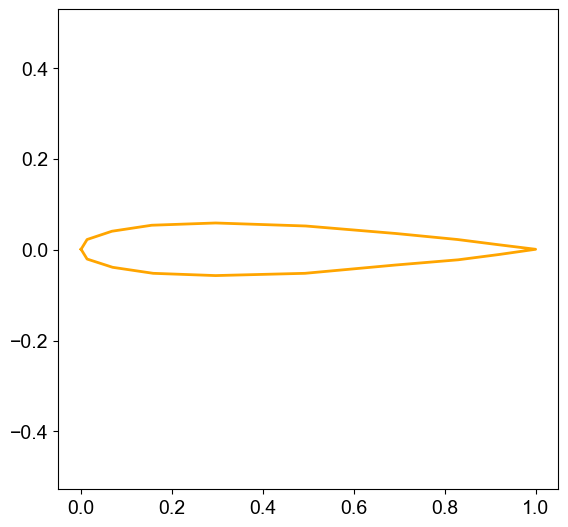

In [112]:
x_af_niemic = [0, 0.013223140495867768, 0.06776859504132231, 0.15537190082644628, 0.2958677685950413, 0.49421487603305786, 0.6925619834710743, 0.828099173553719, 0.9190082644628099, 1, 0.9190082644628099, 0.8297520661157025, 0.6909090909090909, 0.4925619834710744, 0.2958677685950413, 0.1586776859504132, 0.06942148760330578, 0.013223140495867768, 0]
y_af_niemic = [0.0008264462809917106, 0.022314049586776852, 0.04049586776859504, 0.05371900826446274, 0.05867768595041323, 0.05206611570247932, 0.035537190082644665, 0.022314049586776852, 0.01074380165289257, 0.0008264462809917106, -0.01074380165289257, -0.022314049586776852, -0.03388429752066119, -0.052066115702479376, -0.05702479338842975, -0.052066115702479376, -0.03884297520661156, -0.020661157024793375, 0.0008264462809917106]

coords_initial_1 = generate_airfoil_dat_from_points(x0_1, display_plot=False, trailing_edge_smooth_factor=0.1, export_dat=False)
coords_initial_2 = generate_airfoil_dat_from_points(x0_2, display_plot=False, trailing_edge_smooth_factor=0.1, export_dat=False)
coords_initial_3 = generate_airfoil_dat_from_points(x0_3, display_plot=False, trailing_edge_smooth_factor=0.1, export_dat=False)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([0.1,0.1,0.5,0.8])
plt.axis("equal")
#ax.plot(airfoil_coordinates_clarky_flipped[:,0], airfoil_coordinates_clarky_flipped[:,1], color="black", linewidth=2, linestyle='--')
#ax.plot(airfoil_coordinates_hex[:,0]+0.4, airfoil_coordinates_hex[:,1]+0.065, color="black", linewidth=2, linestyle='dashed')
#ax.plot(coords_3[:,0], coords_3[:,1], color="black", linewidth=2)
# ax.plot(coords_initial_1[:,0], coords_initial_1[:,1], color="blue", linewidth=2, linestyle='dashed')
# ax.scatter([0, x0_1[0], x0_1[2], x0_1[4], x0_1[6], 1], [0, x0_1[1], x0_1[3], x0_1[5], x0_1[7], 0], color="blue")
#ax.plot(coords_1[:,0], coords_1[:,1], color="blue", linewidth=2)
#ax.scatter([0, result_1.x[0], result_1.x[2], result_1.x[4], result_1.x[6], 1], [0, result_1.x[1], result_1.x[3], result_1.x[5], result_1.x[7], 0], color="blue")
ax.plot(x_af_niemic, y_af_niemic, color="orange", linewidth=2)
#ax.plot(airfoil_coordinates_naca0012[:,0], airfoil_coordinates_naca0012[:,1], color="red", linewidth=2, linestyle='dashed')

plt.savefig("profile_wing.svg", format="svg")

In [ ]:
airfoil_coordinates_generated = generate_airfoil_dat_from_points(result_2.x, trailing_edge_smooth_factor=0.1, display_plot=True, export_dat=True)

print(np.min(airfoil_coordinates_generated[:,0]))
print(np.max(airfoil_coordinates_generated[:,0]))


In [ ]:
x0_1 = [-0.3021, 0.1624, 0.1866, 0.3144, 0.8114, 0.2288, 1.3155, 0.0637, 0.2794]
x0_2 = [-0.25, 0.25, 0.25, 0.5, 1/2+1/(2*np.sqrt(2)), 1/4, 1+1/(2*np.sqrt(2)), 0, 1/10]
x0_3 = []


# Extract x and y coordinates
x1_values = x0_1[::2]
y1_values = x0_1[1::2]
x2_values = x0_2[::2]
y2_values = x0_2[1::2]

# Ensure equal length
if len(x1_values) > len(y1_values):
    x1_values = x1_values[:-1]
if len(x2_values) > len(y2_values):
    x2_values = x2_values[:-1]

# Plot the points
plt.figure(figsize=(6, 6))
plt.scatter(x1_values, y1_values, color='b', label='Set 1')
plt.scatter(x2_values, y2_values, color='r', label='Set 2')

# Labels and grid
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)
plt.title("Scatter Plot of Given Points")

# Show plot
plt.show()
